In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv('VLM vs YOLOv12.csv', skiprows=1)

print("Data shape:", df.shape)
print("\nFirst few rows:")
df.head()


Data shape: (61, 5)

First few rows:


,filename,estimated_calories,estimated_calories.1,estimated_calories.2,gt_calories
0,00d1b98e-IMG_5920_aug0.jpg,0,0,67.25,44.50
1,0200d27a-IMG_5982.jpg,27,23,26.75,26.75
2,03caea5b-IMG_5882.jpg,147,121,46.75,46.75
3,09ebdcaa-IMG_5850.jpg,121,108,121.25,121.25
4,0bfbc8b7-IMG_5777_aug1.jpg,160,136,114.25,0.00


In [3]:
df.columns = ['filename', 'VLM_lookup', 'VLM_no_lookup', 'YOLOv12', 'Ground_Truth']

for col in ['VLM_lookup', 'VLM_no_lookup', 'YOLOv12', 'Ground_Truth']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nSummary statistics:")
print(df.describe())



Summary statistics:
       VLM_lookup  VLM_no_lookup     YOLOv12  Ground_Truth
count   61.000000      61.000000   61.000000     61.000000
mean   104.704918     123.540984  106.827869    106.344262
std     59.636774      76.917396   55.785780     51.724594
min      0.000000       0.000000    0.000000      0.000000
25%     58.000000      80.000000   65.250000     65.250000
50%    112.000000     108.000000  112.250000    112.250000
75%    147.000000     159.000000  131.000000    131.000000
max    242.000000     330.000000  265.000000    242.000000


In [5]:
# ignore rows where ground truth is 0 
df_valid = df[df['Ground_Truth'] > 0].copy()

In [7]:
# Calculate errors 
def calculate_metrics(y_true, y_pred, method_name):
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    if len(y_true_clean) == 0:
        return None, None, None
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    mape = np.mean(np.abs((y_true_clean - y_pred_clean) / y_true_clean)) * 100
    
    return mae, rmse, mape

methods = {
    'VLM with Lookup': ('VLM_lookup', df_valid['Ground_Truth']),
    'VLM without Lookup': ('VLM_no_lookup', df_valid['Ground_Truth']),
    'YOLOv12': ('YOLOv12', df_valid['Ground_Truth'])
}

results = {}
for method_name, (col_name, gt) in methods.items():
    mae, rmse, mape = calculate_metrics(gt, df_valid[col_name], method_name)
    results[method_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

results_df = pd.DataFrame(results).T
print("\nPerformance (compared to ground truth):")
print("=" * 60)
print(results_df.round(2))



Performance (compared to ground truth):
                      MAE   RMSE   MAPE
VLM with Lookup     15.96  35.52  18.21
VLM without Lookup  43.98  67.90  48.75
YOLOv12              7.80  21.83   7.50


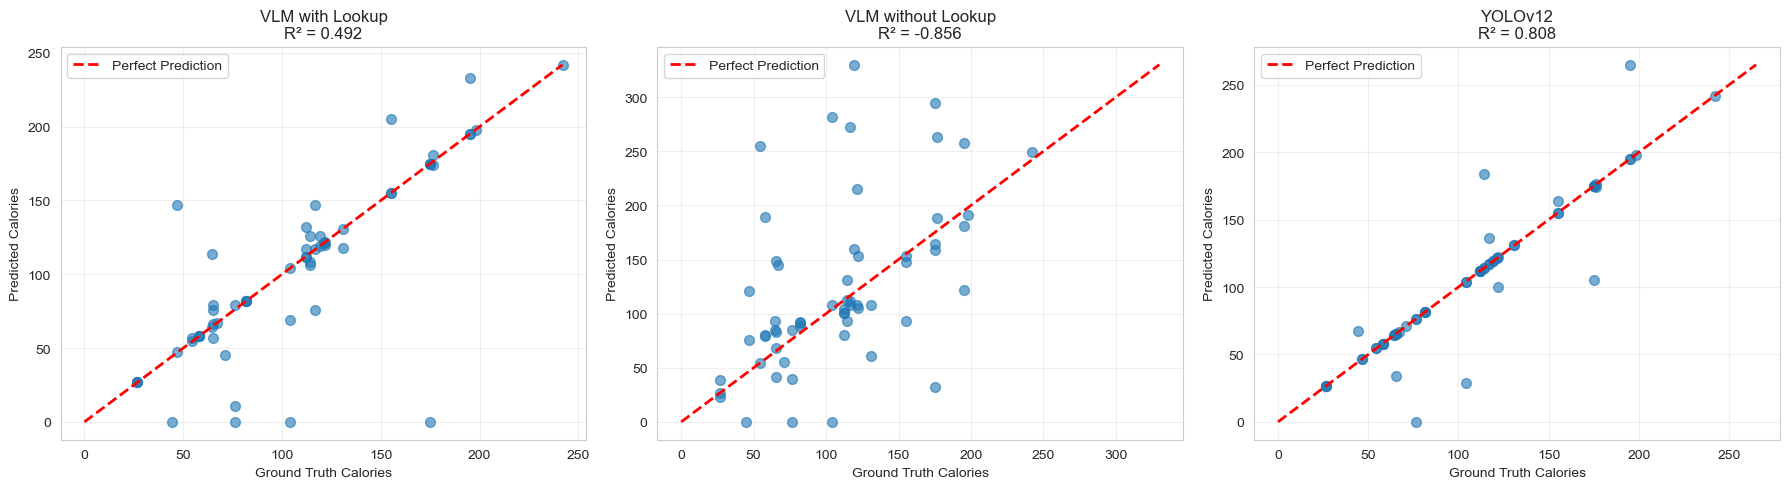

In [8]:
#Scatter plots for predicted vs ground truth 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods_data = [
    ('VLM with Lookup', 'VLM_lookup', axes[0]),
    ('VLM without Lookup', 'VLM_no_lookup', axes[1]),
    ('YOLOv12', 'YOLOv12', axes[2])
]

for method_name, col_name, ax in methods_data:
    valid_mask = ~(np.isnan(df_valid[col_name]) | np.isnan(df_valid['Ground_Truth']))
    pred = df_valid.loc[valid_mask, col_name]
    gt = df_valid.loc[valid_mask, 'Ground_Truth']
    
    ax.scatter(gt, pred, alpha=0.6, s=50)
    
    max_val = max(gt.max(), pred.max())
    min_val = min(gt.min(), pred.min())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate R²
    r2 = r2_score(gt, pred)
    
    ax.set_xlabel('Ground Truth Calories')
    ax.set_ylabel('Predicted Calories')
    ax.set_title(f'{method_name}\nR² = {r2:.3f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
print("Best (lowest MAE):", results_df['MAE'].idxmin())
print("Best (lowest RMSE):", results_df['RMSE'].idxmin())
print("Best (lowest MAPE):", results_df['MAPE'].idxmin())


Best (lowest MAE): YOLOv12
Best (lowest RMSE): YOLOv12
Best (lowest MAPE): YOLOv12
